## Module 4 Project

* Student name: Kyle Aguilar
* Student pace: full time online
* Scheduled project review date/time: Thursday, May 28th, 2020; 10 AM
* Instructor name: Abhineet Kulkarni
* Blog post URL: https://medium.com/@kyle.ags/starting-anew-with-data-science-c3371bd6c9b1


# Introduction

For this project I am using a dataset on Kaggle available [here.](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) to explore neural networks with Keras for the purpose of identifying pneumonia in chest x-rays. My goal is to create a model that performs a binary classification task with a 90% accuracy based on the model's performance on my test data.

# Data Importing and Organization

In [1]:
# importing libraries 

# for navigating directories 
import os, shutil

# for plotting model performance, and displaying images from our data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 

# for timing the model fitting, transforming tensors, preprocessing, and keras visualizations
import datetime
import tensorflow as tf
import scipy
from PIL import Image
from scipy import ndimage

# importing modeling libraries
from keras import layers
from keras import models
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.vis_utils import plot_model
import numpy as np

# setting random seed for replicability
np.random.seed(10)

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
# creating file paths for where our images are stored
data_pneumonia_test = 'data/test/PNEUMONIA/'
data_normal_test = 'data/test/NORMAL/'
data_pneumonia_train = 'data/train/PNEUMONIA/'
data_normal_train = 'data/train/NORMAL/'
data_pneumonia_val = 'data/val/PNEUMONIA/'
data_normal_val = 'data/val/NORMAL/'

# saving directory names for each part of the split 
data_train = 'data/train'
data_test = 'data/test'
data_val = 'data/val'

# creating list of data folders
data_folders = [data_pneumonia_test, data_normal_test, data_pneumonia_train,
                data_normal_train, data_pneumonia_val, data_normal_val]

In [3]:
# checking for unfavorable class imbalance
folder_size = [print(f'There are {len(os.listdir(i))} images in the {i} set')\
               for i in data_folders]

There are 390 images in the data/test/PNEUMONIA/ set
There are 234 images in the data/test/NORMAL/ set
There are 3875 images in the data/train/PNEUMONIA/ set
There are 1341 images in the data/train/NORMAL/ set
There are 8 images in the data/val/PNEUMONIA/ set
There are 8 images in the data/val/NORMAL/ set


Surprisingly, it appears that we have more pneumonia images than we have normal images. However, both the size of the validation data and the test data look disproportionately small considering the size of the dataset.

## Check for Class Imbalance

In [4]:
# counting pneumonia and normal files in directory
total_images = 0
pneumonia_images = 0
normal_images = 0
for file in data_folders:
    total_images += len(os.listdir(file))
    if 'PNEUMONIA' in str(file):
        pneumonia_images += len(os.listdir(file))
    else:
        normal_images += len(os.listdir(file))
print(f'Total Images: {total_images}')
print(f'{round(pneumonia_images/total_images, 2)}% of images have pneumonia')
print(f'{round(normal_images/total_images, 2)}% of images are normal')

Total Images: 5856
0.73% of images have pneumonia
0.27% of images are normal


There is certainly class imbalance among the images - however, as it is imbalanced in favor of the class we are working to identify, I will not take any further actions to resample the normal images. However, I will move images from the train folders into the test and validation folders in order to achieve closer to a 75/15/15 split. 15% of our images is 878, so I will proportionally move images into the test and validation sets. 

## Create Balanced Train/Test/Validation Split

In [5]:
# determining number of images that need to be moved to balance our test/train/validation split
print(f'Images to move to test-pneumonia {(878 * .73) - len(os.listdir(data_pneumonia_test))}')
print(f'Images to move to test-normal {(878 * .27) - len(os.listdir(data_normal_test))}')
print(f'Images to move to val-pneumonia {(878 * .73) - len(os.listdir(data_pneumonia_val))}')
print(f'Images to move to val-normal {(878 * .27) - len(os.listdir(data_normal_val))}')

Images to move to test-pneumonia 250.93999999999994
Images to move to test-normal 3.0600000000000023
Images to move to val-pneumonia 632.9399999999999
Images to move to val-normal 229.06


In [6]:
# creating list of files in training set to be moved
data_pneumonia_files = [file for file in os.listdir(data_pneumonia_train)]
data_normal_files = [file for file in os.listdir(data_normal_train)]

# checking first ten files in training set
data_pneumonia_files[:10]

['person1000_bacteria_2931.jpeg',
 'person1000_virus_1681.jpeg',
 'person1001_bacteria_2932.jpeg',
 'person1002_bacteria_2933.jpeg',
 'person1003_bacteria_2934.jpeg',
 'person1003_virus_1685.jpeg',
 'person1004_bacteria_2935.jpeg',
 'person1004_virus_1686.jpeg',
 'person1005_bacteria_2936.jpeg',
 'person1005_virus_1688.jpeg']

In [7]:
# increasing size of test-pneumonia data
imgs = data_pneumonia_files[-250:]
for img in imgs:
    origin = os.path.join(data_pneumonia_train, img)
    destination = data_pneumonia_test
    shutil.move(origin, destination)
    
# increasing size of test-normal data
imgs = data_normal_files[-3:]
for img in imgs:
    origin = os.path.join(data_normal_train, img)
    destination = data_normal_test
    shutil.move(origin, destination)

In [8]:
# updating list of training files eligible for moving
data_pneumonia_files = [file for file in os.listdir(data_pneumonia_train)]
data_normal_files = [file for file in os.listdir(data_normal_train)]

# increasing size of val-pneumonia data
imgs = data_pneumonia_files[-632:]
for img in imgs:
    origin = os.path.join(data_pneumonia_train, img)
    destination = data_pneumonia_val
    shutil.move(origin, destination)
    
# increasing size of val-normal data
imgs = data_normal_files[-229:]
for img in imgs:
    origin = os.path.join(data_normal_train, img)
    destination = data_normal_val
    shutil.move(origin, destination)

In [9]:
# checking for more balanced train/test/validation data split
folder_size = [print(f'There are {len(os.listdir(i))} images in the {i} set') for i in data_folders]

There are 640 images in the data/test/PNEUMONIA/ set
There are 237 images in the data/test/NORMAL/ set
There are 2993 images in the data/train/PNEUMONIA/ set
There are 1109 images in the data/train/NORMAL/ set
There are 640 images in the data/val/PNEUMONIA/ set
There are 237 images in the data/val/NORMAL/ set


# Image Visualizations

Let's take a look at an image from each of our two classes. As someone with no medical background, I don't expect to be able to identify clearly when an x-ray indicates pneumonia. Additionally, it will be helpful to see what the images look like as we will be doing some data augmentation later.

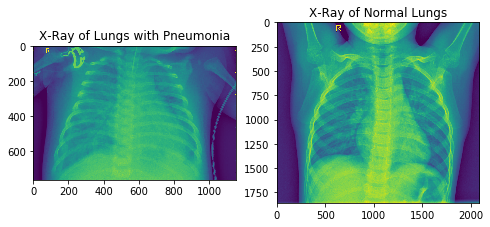

In [10]:
# visualizing an image from each of our two classes side-by-side
pneumonia_img = mpimg.imread(os.path.join(data_pneumonia_train, data_pneumonia_files[0]))
normal_img = mpimg.imread(os.path.join(data_normal_train, data_normal_files[0]))

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(pneumonia_img)
ax1.set_title('X-Ray of Lungs with Pneumonia')
ax2.imshow(normal_img)
ax2.set_title('X-Ray of Normal Lungs')
plt.show()

# Preparing Data with Augmentation

Our images are in a variety of sizes, so let's resize all of our images to 128x128. Additionally, as these are RGB images, so image data is being rescaled by dividing by 255. For now I am not passing any parameters besides rescale into the Image Data Generator, I am just using our data as-is. 

In [4]:
# getting all the data in the test directory (4102 images), rescaling and reshaping
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train, target_size=(128,128), batch_size=32, class_mode='binary') 

# getting all the data in the test directory (877 images), rescaling and reshaping
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test, target_size=(128,128), batch_size=877, class_mode='binary') 

# getting all the data in the test directory (877 images), rescaling and reshaping
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val, target_size=(128,128), batch_size=32, class_mode='binary') 

# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 4102 images belonging to 2 classes.
Found 877 images belonging to 2 classes.
Found 877 images belonging to 2 classes.


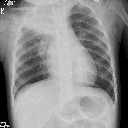

In [12]:
array_to_img(train_images[10])

# Models

I will be compiling these models and evaluating their performance using binary crossentropy and accuracy on the validation set of data. As our data is split into test, train and validation, I will also be using a test set to measure model accuracy and ensure that we have a complete view of how my model is performing.

In [13]:
# defining function to visualize model performance
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [7]:
# importing sklearn for further evaluation of model performance
import scikitplot as skplt
from sklearn.metrics import classification_report

## Baseline CNN Model

For my baseline model I am employing a convoluted neural network in order to identify patterns and edges in these images. I am also employing early stopping criterion and saving the best performing model, in case the model ceases to improve after 10 epochs. I am assuming that this will provide an overfit model given the number of layers and parameters that are being trained, to be followed by a shorter model incorporating data augmentation.

In [15]:
# importing EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# defining stopping criterion
early_stopping = [EarlyStopping(monitor='val_loss', patience=20), 
                  ModelCheckpoint(filepath='best_model.h5', verbose=2, monitor='val_loss', save_best_only=True)]

There are three layers of the CNN (one input and two hidden), followed by three Dense hidden layers, and an output layer with a sigmoid activation since we are working with a binary classification problem. In between each convolutional layer I have also added a pooling layer to reduce sensitivity to the location of features. As every chest x-ray is going to have many minute differences (e.g. rotation, scale, size/proportions of the chest being x-rayed, cropping), this practice summarizes the features that have been detected in the Conv2D layer.


In [3]:
# building baseline CNN
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(128,128,3), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['acc'])

Let's see how many total parameters are trainable in this model, to get a better sense of how complex our model is. 

In [17]:
# reviewing model layers
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 128)     3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        9248      
__________

In [4]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
# running model with steps based on number of train and val samples / batch size
start = datetime.datetime.now()
history_baseline = model.fit_generator(train_generator,
                                       epochs=50,
                                       steps_per_epoch=128,
                                       callbacks=early_stopping,
                                       validation_data=val_generator,
                                       validation_steps=27
                                      )
end = datetime.datetime.now()
elapsed = end - start

print(f'This model took {elapsed} time to run.')

Epoch 1/50
128/128 [==============================] - 113s 880ms/step - loss: 0.3731 - acc: 0.8559 - val_loss: 0.3011 - val_acc: 0.8951

Epoch 00001: val_loss improved from inf to 0.30106, saving model to best_model.h5
Epoch 2/50
128/128 [==============================] - 110s 860ms/step - loss: 0.1770 - acc: 0.9346 - val_loss: 0.1300 - val_acc: 0.9498

Epoch 00002: val_loss improved from 0.30106 to 0.13004, saving model to best_model.h5
Epoch 3/50
128/128 [==============================] - 110s 859ms/step - loss: 0.1278 - acc: 0.9497 - val_loss: 0.1637 - val_acc: 0.9384

Epoch 00003: val_loss did not improve from 0.13004
Epoch 4/50
128/128 [==============================] - 111s 867ms/step - loss: 0.1047 - acc: 0.9604 - val_loss: 0.1087 - val_acc: 0.9578

Epoch 00004: val_loss improved from 0.13004 to 0.10873, saving model to best_model.h5
Epoch 5/50
128/128 [==============================] - 111s 868ms/step - loss: 0.0853 - acc: 0.9700 - val_loss: 0.1333 - val_acc: 0.9578

Epoch 0000

### Visualizations

#### Model Performance Over Epochs

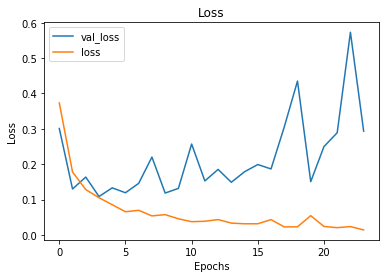

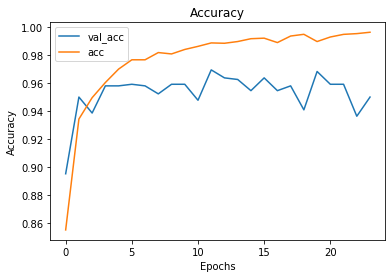

In [21]:
# displaying model performance
visualize_training_results(history_baseline)

#### Intermediate Activations

In [22]:
# displaying intermediate activations for a single image in the dataset
img_path = data_pneumonia_files[0]
img = load_img(os.path.join(data_pneumonia_train, img_path), target_size=(128,128))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [23]:
# Extracting model layer outputs through layer 6
layer_outputs = [layer.output for layer in model.layers[:6]]

# instantiates model to return outputs, running model
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

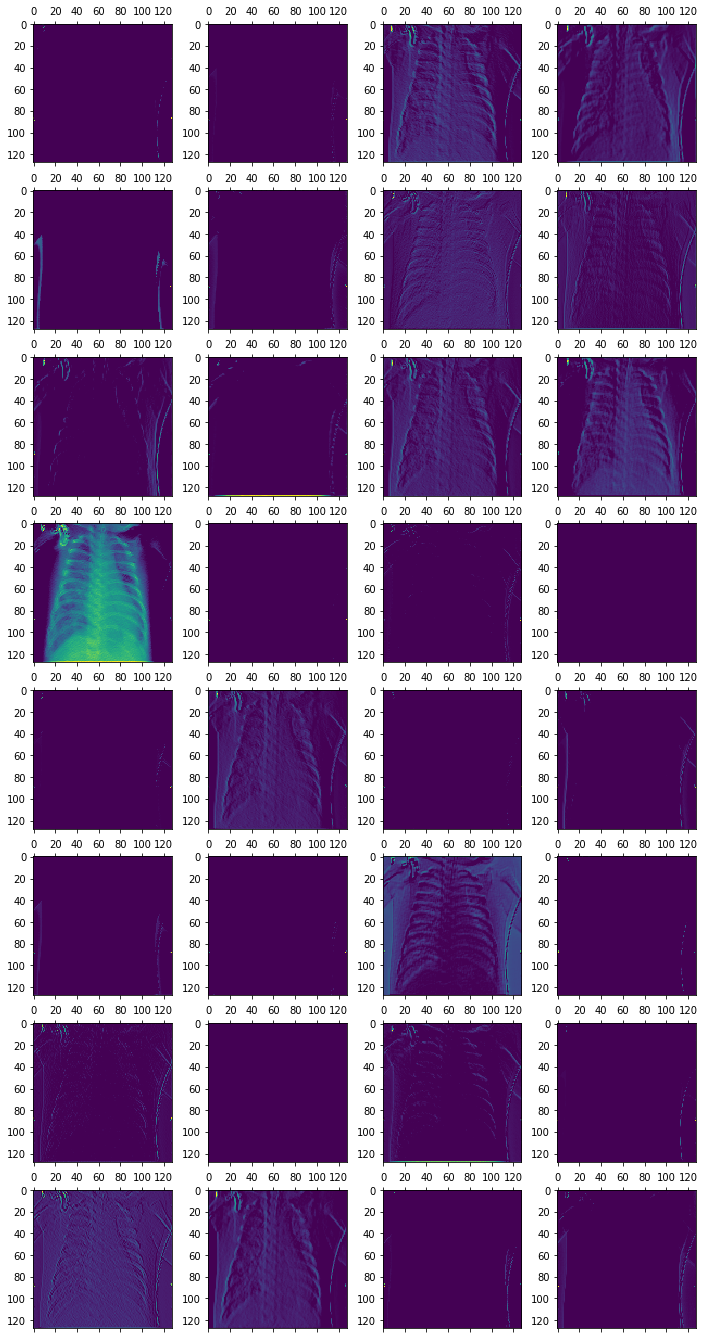

In [24]:
# displaying all of the activations of the image across the layer
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

### Evaluation

In [5]:
# loading saved model
from keras.models import load_model
saved_model = load_model('best_model.h5')

# evaluating model with test data
test_loss, test_acc = saved_model.evaluate_generator(test_generator, steps=1)
print(test_loss, test_acc)

0.6531161069869995 0.8380843997001648


In [8]:
# using saved model to predict classes on test images
predictions = saved_model.predict_classes(test_images)
print(classification_report(test_labels, predictions, target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.93      0.43      0.59       237
   Pneumonia       0.83      0.99      0.90       640

    accuracy                           0.84       877
   macro avg       0.88      0.71      0.75       877
weighted avg       0.85      0.84      0.82       877



Text(0.5, 1.0, 'Confusion Matrix for Baseline CNN')

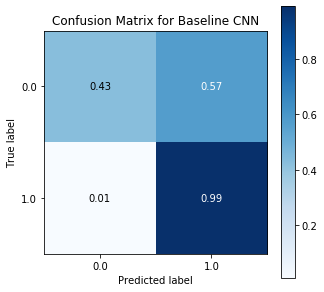

In [9]:
# displaying confusion matrix for baseline model
skplt.metrics.plot_confusion_matrix(test_labels, predictions, figsize=(5,5), normalize=True)
plt.title(f'Confusion Matrix for Baseline CNN')

## CNN Model with Data Augmentation

Our CNN model, using only our training data of around 4K samples performed fairly well. However, given that this can be considered a small data set, would benefit greatly from data augmentation. I am using a diverse set of parameters to build on our sample size, including shifting, rotation, shear transformation, and brightness to create images that would be reasonably warped x-rays. I am running this model on the same parameters as our prior CNN to compare the outcome of performance on our test data, so no changes are being made to any of the layers for a just comparison of performance, nor are any changes being made to the test or validation datasets, which will remain the same (generated and rescaled).

In [31]:
# establishing parameters to generate additional samples
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.4,
                                   brightness_range=[0.2,1.0],
                                   channel_shift_range=150.0,
                                   fill_mode='nearest')


# getting all the data in the train dataset with data augmentation
train_generator_da = train_datagen.flow_from_directory(data_train, 
                                                       batch_size=32,
                                                       target_size=(128,128),
                                                       class_mode='binary') 


# creating the data sets
train_images, train_labels = next(train_generator_da)

Found 4102 images belonging to 2 classes.


In [32]:
# defining stopping criterion
early_stopping_da = [EarlyStopping(monitor='val_loss', patience=20),
                     ModelCheckpoint(filepath='best_model_augmented.h5', verbose=2, monitor='val_loss', save_best_only=True)]

In [33]:
# running model with data augmentation
start = datetime.datetime.now()
history_augmented = model.fit_generator(train_generator_da,
                                       epochs=50,
                                       steps_per_epoch=128,
                                       callbacks=early_stopping_da,
                                       validation_data=val_generator,
                                       validation_steps=27
                                      )
end = datetime.datetime.now()
elapsed = end - start

print(f'This model took {elapsed} time to run.')

Epoch 1/50
128/128 [==============================] - 112s 872ms/step - loss: 0.6263 - acc: 0.7301 - val_loss: 0.3610 - val_acc: 0.8153

Epoch 00001: val_loss improved from inf to 0.36096, saving model to best_model_augmented.h5
Epoch 2/50
128/128 [==============================] - 111s 871ms/step - loss: 0.5097 - acc: 0.7401 - val_loss: 0.2454 - val_acc: 0.9282

Epoch 00002: val_loss improved from 0.36096 to 0.24537, saving model to best_model_augmented.h5
Epoch 3/50
128/128 [==============================] - 111s 870ms/step - loss: 0.4791 - acc: 0.7610 - val_loss: 0.2806 - val_acc: 0.9247

Epoch 00003: val_loss did not improve from 0.24537
Epoch 4/50
128/128 [==============================] - 111s 870ms/step - loss: 0.4735 - acc: 0.7613 - val_loss: 0.3670 - val_acc: 0.9019

Epoch 00004: val_loss did not improve from 0.24537
Epoch 5/50
128/128 [==============================] - 112s 877ms/step - loss: 0.4627 - acc: 0.7654 - val_loss: 0.4410 - val_acc: 0.8974

Epoch 00005: val_loss did

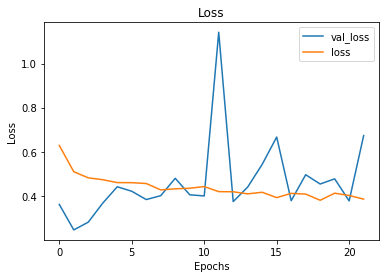

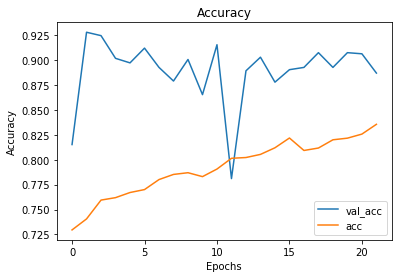

In [34]:
# displaying model performance
visualize_training_results(history_augmented)

In [10]:
# loading saved model
saved_model_da = load_model('best_model_augmented.h5')

# evaluating model with test data
test_loss, test_acc = saved_model_da.evaluate_generator(test_generator, steps=1)
print(test_loss, test_acc)

0.9437641501426697 0.7844926118850708


In [11]:
# using saved model to predict classes on test images
predictions_da = saved_model_da.predict_classes(test_images)
print(classification_report(test_labels, predictions_da, target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.83      0.25      0.39       237
   Pneumonia       0.78      0.98      0.87       640

    accuracy                           0.78       877
   macro avg       0.81      0.62      0.63       877
weighted avg       0.79      0.78      0.74       877



Text(0.5, 1.0, 'Confusion Matrix for Data Augmented CNN')

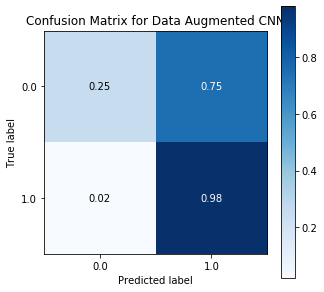

In [12]:
# displaying confusion matrix for baseline model
skplt.metrics.plot_confusion_matrix(test_labels, predictions_da, figsize=(5,5), normalize=True)
plt.title(f'Confusion Matrix for Data Augmented CNN')

## Transfer Learning Model - VGG-19 with Data Augmentation

As our images are not a part of the classes that imagenet is trained to classify, I will be using a pretrained network, VGG19, and adding dense layers and training this extended model on my augmented training data. I am also freezing the VGG19 layer so that it is not trainable, and therefore only the existing weights are being used as-is, and not being updated during training. 

In [18]:
# importing model for transfer learning model
from keras.applications.vgg19 import VGG19
from keras.layers import Input

# instantiating base CNN model and 
model_base = VGG19(include_top=False,
                   weights='imagenet',
                   input_shape=(128, 128,3))
model_base.trainable = False

# setting parameters for VGG19 model, loading pretrained weights and selecting max # of each tensor movement
model_VGG19 = models.Sequential()
model_VGG19.add(model_base)

# adding Dense layers (same dimensions as prior models)
model_VGG19.add(layers.Flatten())
model_VGG19.add(layers.Dense(512, activation='relu'))
model_VGG19.add(layers.Dense(256, activation='relu'))
model_VGG19.add(layers.Dense(128, activation='relu'))
model_VGG19.add(layers.Dense(64, activation='relu'))
model_VGG19.add(layers.Dense(1, activation='sigmoid'))

model_VGG19.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['acc'])

model_VGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 24,293,185
Trainable params: 4,268,801
Non-trainable params: 20,024,384
________________________________________________________

In [19]:
# defining stopping criterion
early_stopping_VGG19 = [EarlyStopping(monitor='val_loss', patience=20),
                     ModelCheckpoint(filepath='best_model_VGG19.h5', verbose=2, monitor='val_loss', save_best_only=True)]

In [20]:
# running VGG19 model with data augmentation
start = datetime.datetime.now()
history_VGG19 = model_VGG19.fit_generator(train_generator_da,
                                       epochs=50,
                                       steps_per_epoch=64,
                                       callbacks=early_stopping_VGG19,
                                       validation_data=val_generator)
end = datetime.datetime.now()
elapsed = end - start

print(f'This model took {elapsed} time to run.')

Epoch 1/50
64/64 [==============================] - 199s 3s/step - loss: 0.7400 - acc: 0.7031 - val_loss: 0.3886 - val_acc: 0.7617

Epoch 00001: val_loss improved from inf to 0.38858, saving model to best_model_VGG19.h5
Epoch 2/50
64/64 [==============================] - 201s 3s/step - loss: 0.5397 - acc: 0.7481 - val_loss: 0.4907 - val_acc: 0.8005

Epoch 00002: val_loss did not improve from 0.38858
Epoch 3/50
64/64 [==============================] - 201s 3s/step - loss: 0.5141 - acc: 0.7720 - val_loss: 0.2411 - val_acc: 0.9361

Epoch 00003: val_loss improved from 0.38858 to 0.24109, saving model to best_model_VGG19.h5
Epoch 4/50
64/64 [==============================] - 204s 3s/step - loss: 0.4831 - acc: 0.7794 - val_loss: 0.3203 - val_acc: 0.8848

Epoch 00004: val_loss did not improve from 0.24109
Epoch 5/50
64/64 [==============================] - 204s 3s/step - loss: 0.4560 - acc: 0.8002 - val_loss: 0.3409 - val_acc: 0.8826

Epoch 00005: val_loss did not improve from 0.24109
Epoch 6

In [13]:
# loading saved model
saved_model_VGG = load_model('best_model_VGG19.h5')

# evaluating model with test data
test_loss, test_acc = saved_model_VGG.evaluate_generator(test_generator, steps=1)
print(test_loss, test_acc)

0.25979331135749817 0.9042189121246338


In [14]:
# using saved model to predict classes on test images
predictions_VGG = saved_model_VGG.predict_classes(test_images)
print(classification_report(test_labels, predictions_VGG, target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.88      0.75      0.81       237
   Pneumonia       0.91      0.96      0.94       640

    accuracy                           0.90       877
   macro avg       0.89      0.86      0.87       877
weighted avg       0.90      0.90      0.90       877



Text(0.5, 1.0, 'Confusion Matrix for VGG Model')

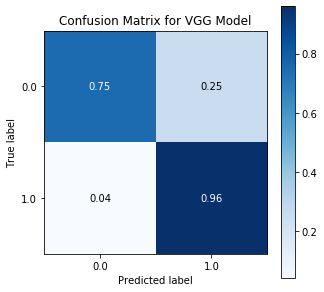

In [15]:
# displaying confusion matrix for baseline model
skplt.metrics.plot_confusion_matrix(test_labels, predictions_VGG, figsize=(5,5), normalize=True)
plt.title(f'Confusion Matrix for VGG Model')

# Conclusion

Our VGG-19 performed the best in regards to accuracy and F-1 of our three highlighted models and performed better at not overclassifying patients with pneumonia. Our CNN from scratch achieved the highest recall, but along the way clasified over 50% of healthy patients as having pneumonia. Either seem to be a very viable model for implementing to identify x-rays, and it is worth continuing to feed new data to expand our training set as we continue to iterate.


## Next Steps

There are many possibilities to explore in the application of this model on new data.
* Some x-rays are taken from the side. A decision could perhaps be even more clearly made if there were another model run on x-rays from this angle to increase the perception of whether a patient has pneumonia, if in fact taking these additional x-rays makes sense for the cost/effort involved.
* Additional classes of diagnoses - either types of pneumonia and other illnesses or irregularities that are visible in a chest x-ray could be added to a model, assuming that there are other conditions that would be helpful to spot, or that may be confused for pneumonia. 
* It would benefit the medical community if a larger dataset of medical conditions akin to the imagenet dataset were available for neural networks such as VGG-19 to be trained on.